In [9]:
import numpy as np
import pandas as pd
import tushare as ts
from talib.abstract import *
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math

from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics

In [10]:
#import os
os.chdir('/Users/xupech/Downloads/Final Project/Data')

In [11]:
sp500 = pd.read_csv('./XLU.csv')


In [13]:
sp500.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume
3336,2020-04-03,53.119999,53.779999,51.389999,51.790001,51.790001,15936000
3337,2020-04-06,53.689999,56.349998,53.689999,55.790001,55.790001,20689800
3338,2020-04-07,57.290001,57.380001,55.020000,55.090000,55.090000,24581600
3339,2020-04-08,55.419998,58.570000,54.959999,58.090000,58.090000,32462800
3340,2020-04-09,58.970001,61.779999,58.750000,60.830002,60.830002,43862000
3341,2020-04-13,60.520000,60.520000,58.310001,58.900002,58.900002,13915200
3342,2020-04-14,60.169998,60.720001,59.590000,60.630001,60.630001,17087800
3343,2020-04-15,58.959999,59.680000,58.299999,58.630001,58.630001,12835800
3344,2020-04-16,58.880001,59.130001,58.060001,58.639999,58.639999,10400000
3345,2020-04-17,59.889999,60.849998,59.080002,60.529999,60.529999,10777500


In [14]:
sp500.index = sp500.Date
del sp500['Date']

# Log of Close Price
sp500['plog'] = np.log(sp500.Close)

# Log of Volume
sp500['vlog'] = np.log(sp500.Volume)

sp500 = sp500[:'2020-01-11']

sp500.tail(5)

,Open,High,Low,Close,Adj Close,Volume,plog,vlog
Date,,,,,,,,
2020-01-06,63.860001,64.190002,63.759998,64.000000,63.365620,10444500,4.158883,16.161586
2020-01-07,63.840000,63.939999,63.549999,63.910000,63.276512,13070300,4.157476,16.385853
2020-01-08,63.939999,64.160004,63.779999,63.880001,63.246811,12741400,4.157006,16.360367
2020-01-09,63.799999,64.300003,63.790001,64.230003,63.593342,11643100,4.162470,16.270224
2020-01-10,64.320000,64.629997,64.290001,64.400002,63.761658,10582900,4.165114,16.174750


In [15]:
# ret: Return.
sp500['lag_plog']=sp500.plog.shift(1)
sp500['ret']=sp500['plog']-sp500['lag_plog']

# rollstd: Rolling 14-day return standard deviation will be used as a feature to predict volatility. It takes clustering
# effect into consideration and will look back 14 days to compute standard deviation. Arbitrary number, worth 
# thinking over again.
sp500['rollstd']=sp500['ret'].rolling(14).std()

# voldiff: Volume difference, this will be used as input variable to predict volatility.
sp500['lag_vlog']=sp500.vlog.shift(1)
sp500['voldiff'] = sp500['vlog']-sp500['lag_vlog']


# Get rid of Nan values.
sp500 = sp500[14:]
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff
Date,,,,,,,,,,,,,
2020-01-06,63.860001,64.190002,63.759998,64.000000,63.365620,10444500,4.158883,16.161586,4.157945,0.000938,0.005912,16.705288,-0.543702
2020-01-07,63.840000,63.939999,63.549999,63.910000,63.276512,13070300,4.157476,16.385853,4.158883,-0.001407,0.004873,16.161586,0.224267
2020-01-08,63.939999,64.160004,63.779999,63.880001,63.246811,12741400,4.157006,16.360367,4.157476,-0.000470,0.004765,16.385853,-0.025486
2020-01-09,63.799999,64.300003,63.790001,64.230003,63.593342,11643100,4.162470,16.270224,4.157006,0.005464,0.004885,16.360367,-0.090143
2020-01-10,64.320000,64.629997,64.290001,64.400002,63.761658,10582900,4.165114,16.174750,4.162470,0.002643,0.004952,16.270224,-0.095474


In [16]:
# absret: Return in absolute form as a measure for volatility.
sp500['absret'] = abs(sp500['ret'])

print(np.mean(sp500['ret']))
# sqret: Mean of return small, assume data around zero and use squared return to denote volatility. Will need to take
# squared root in order to compare predicted results with real results later.
sp500['sqret'] = np.square(sp500['ret'])

0.0001760105001119523


In [18]:
# 0.7% as a threshold to determine if volatility is significant and entails more than noise, and thus price movement
# can be explained and forecasted using a price movement model.

# rollstd_07: determine if rollstd > 0.7%.
sp500['rollstd_07'] = sp500.rollstd>0.007
# absret_07: determine is absret > 0.7%.
sp500['absret_07'] = sp500.absret>0.007
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff,absret,sqret,rollstd_07,absret_07
Date,,,,,,,,,,,,,,,,,
2020-01-06,63.860001,64.190002,63.759998,64.000000,63.365620,10444500,4.158883,16.161586,4.157945,0.000938,0.005912,16.705288,-0.543702,0.000938,8.797603e-07,False,False
2020-01-07,63.840000,63.939999,63.549999,63.910000,63.276512,13070300,4.157476,16.385853,4.158883,-0.001407,0.004873,16.161586,0.224267,0.001407,1.980324e-06,False,False
2020-01-08,63.939999,64.160004,63.779999,63.880001,63.246811,12741400,4.157006,16.360367,4.157476,-0.000470,0.004765,16.385853,-0.025486,0.000470,2.204346e-07,False,False
2020-01-09,63.799999,64.300003,63.790001,64.230003,63.593342,11643100,4.162470,16.270224,4.157006,0.005464,0.004885,16.360367,-0.090143,0.005464,2.985638e-05,False,False
2020-01-10,64.320000,64.629997,64.290001,64.400002,63.761658,10582900,4.165114,16.174750,4.162470,0.002643,0.004952,16.270224,-0.095474,0.002643,6.986645e-06,False,False


In [19]:
# Number of days when volatility greater than 0.7%, when a trading position will be forwarded.
print(len(sp500[sp500.absret>0.007]))

# Divided by number of trading days in the same period, sort of get the trading frequency.
print(1/(len(sp500[sp500.absret>0.007])/len(sp500)))

1314
2.484779299847793


In [20]:
#Split train/test set.
trainset = sp500.loc[:'2018-06-21']
testset = sp500.loc['2018-06-21':]

# Length of train/test set.
ltrain = len(trainset)
ltest = len(testset)

#Proportion of trainset on total dataset.
print(len(testset)/len(sp500))

0.12006125574272589


In [21]:
# Helper Function.
# Variable rescaling function for model fitting.
def reshape(var):
    v_var = var.reshape(-1,1)
    v_var = v_var.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled variable.
    output = scaler.fit_transform(v_var)
    return output, scaler

# Create lookback variables， default lookback period = 1.
# Lookback on itself.
def create_dataset0(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
# Lookback on an extra variable.
def create_dataset1(Xset, Yset,look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xset) - look_back):
        a = Xset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(Yset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [22]:
# All variables that will be used in models.

# Dependent variables. Lags as X variables will be created upon Y variables later.
absret = sp500.absret.values
# Scaled.
v_absret, scaler_absret = reshape(absret)

sqret =sp500.sqret.values
# Scaled.
v_sqret, scaler_sqret = reshape(sqret)

# Dummy variable.
absret_07 = sp500.absret_07.values
# Rescaled so that it can fit in create_dataset function.
v_absret07, scaler_absret07 =reshape(absret_07)
# Now datatype is float, ecessary to convert back to boolean?
v_absret07 = v_absret07.astype('bool_')

# Extra X variables.
rollstd = sp500.rollstd.values
# Scaled.
v_rollstd, scaler_rollstd = reshape(rollstd)

#Dummy variable.
rollstd_07 = sp500.rollstd_07.values
v_rollstd07, scaler_rollstd07 = reshape(rollstd_07)
v_rollstd07 = v_rollstd07.astype('bool_')

vlog = sp500.vlog.values
#Scaled.
v_vlog, scaler_vlog = reshape(vlog)

voldiff = sp500.voldiff.values
#Scaled.
v_voldiff, scaler_voldiff = reshape(voldiff)

rolldiff = sp500.absret.values - sp500.rollstd.values
# Scaled.
v_rolldiff, scaler_rolldiff = reshape(rolldiff)

sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff,absret,sqret,rollstd_07,absret_07
Date,,,,,,,,,,,,,,,,,
2020-01-06,63.860001,64.190002,63.759998,64.000000,63.365620,10444500,4.158883,16.161586,4.157945,0.000938,0.005912,16.705288,-0.543702,0.000938,8.797603e-07,False,False
2020-01-07,63.840000,63.939999,63.549999,63.910000,63.276512,13070300,4.157476,16.385853,4.158883,-0.001407,0.004873,16.161586,0.224267,0.001407,1.980324e-06,False,False
2020-01-08,63.939999,64.160004,63.779999,63.880001,63.246811,12741400,4.157006,16.360367,4.157476,-0.000470,0.004765,16.385853,-0.025486,0.000470,2.204346e-07,False,False
2020-01-09,63.799999,64.300003,63.790001,64.230003,63.593342,11643100,4.162470,16.270224,4.157006,0.005464,0.004885,16.360367,-0.090143,0.005464,2.985638e-05,False,False
2020-01-10,64.320000,64.629997,64.290001,64.400002,63.761658,10582900,4.165114,16.174750,4.162470,0.002643,0.004952,16.270224,-0.095474,0.002643,6.986645e-06,False,False


3265

In [23]:
# Create a dataframe to use 1-lag rollstd, voldiff, absret as input variables.
d = absret[1:]
a = absret[:-1]
b = rollstd[:-1]
c = voldiff[:-1]

df_inputs=pd.DataFrame({'a':a, 'b':b, 'c':c, 'd':d}) 
df_inputs = df_inputs.values

In [28]:
df_inputs

array([[ 3.30485020e-03,  5.88491529e-03, -1.51916946e-01,
         8.25168536e-04],
       [ 8.25168536e-04,  5.88329147e-03,  4.01327481e-01,
         2.47968167e-03],
       [ 2.47968167e-03,  3.24480028e-03, -8.22226827e-01,
         3.30485020e-03],
       ...,
       [ 1.40723970e-03,  4.87310692e-03,  2.24266957e-01,
         4.69504661e-04],
       [ 4.69504661e-04,  4.76504687e-03, -2.54859465e-02,
         5.46409898e-03],
       [ 5.46409898e-03,  4.88482403e-03, -9.01428043e-02,
         2.64322619e-03]])

In [411]:
scaler = StandardScaler().fit(df_inputs)
df_inputs = scaler.transform(df_inputs)

xtrain, xtest = df_inputs[0:ltrain-1,:-1], df_inputs[ltrain-1:,:-1]
ytrain, ytest = df_inputs[0:ltrain-1, -1], df_inputs[ltrain-1:, -1]

In [412]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [413]:
# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

Train on 2873 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 1.0493 - val_loss: 0.4986
Epoch 2/100
 - 0s - loss: 1.0051 - val_loss: 0.4914
Epoch 3/100
 - 0s - loss: 0.9727 - val_loss: 0.4858
Epoch 4/100
 - 0s - loss: 0.9454 - val_loss: 0.4817
Epoch 5/100
 - 0s - loss: 0.9167 - val_loss: 0.4791
Epoch 6/100
 - 0s - loss: 0.9016 - val_loss: 0.4776
Epoch 7/100
 - 0s - loss: 0.8820 - val_loss: 0.4766
Epoch 8/100
 - 0s - loss: 0.8737 - val_loss: 0.4757
Epoch 9/100
 - 0s - loss: 0.8632 - val_loss: 0.4751
Epoch 10/100
 - 0s - loss: 0.8528 - val_loss: 0.4742
Epoch 11/100
 - 0s - loss: 0.8530 - val_loss: 0.4732
Epoch 12/100
 - 0s - loss: 0.8575 - val_loss: 0.4720
Epoch 13/100
 - 0s - loss: 0.8478 - val_loss: 0.4708
Epoch 14/100
 - 0s - loss: 0.8428 - val_loss: 0.4700
Epoch 15/100
 - 0s - loss: 0.8447 - val_loss: 0.4693
Epoch 16/100
 - 0s - loss: 0.8481 - val_loss: 0.4688
Epoch 17/100
 - 0s - loss: 0.8420 - val_loss: 0.4681
Epoch 18/100
 - 0s - loss: 0.8421 - val_loss: 0.4675
Epoch 19

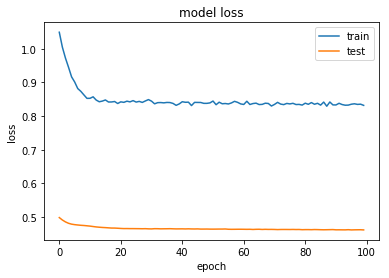

In [414]:
# Plot to show loss v.s. epoch and determine optimal epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [415]:
# Have real yhat and real ytest ready for comparison.

# make a prediction
yhat = model.predict(xtest)
xtest = xtest.reshape((xtest.shape[0], xtest.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((xtest,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
yhat_inverse = inv_yhat[:,-1]

# invert scaling for actual
ytest = ytest.reshape((len(ytest), 1))
inv_y = np.concatenate((xtest, ytest), axis=1)
inv_y = scaler.inverse_transform(inv_y)
ytest_inverse = inv_y[:,-1]

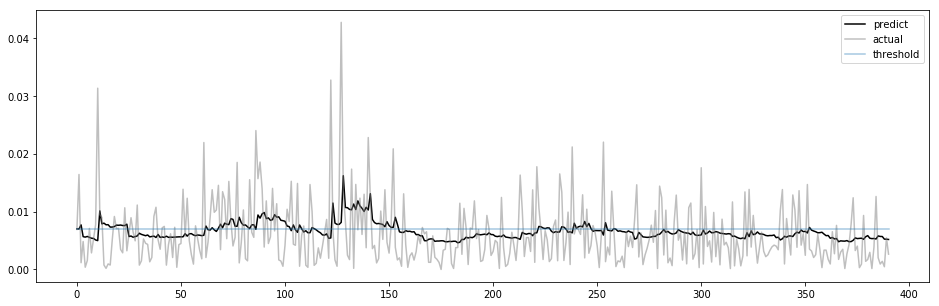

In [416]:
# Set threshold to be 0.7% and generate a plot of predicted volatility v.s. actual volatility and threshold.
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

In [365]:
# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true08'] = testtable['true']<0.008
testtable['hat08'] = testtable['hat']<0.008
print(testtable.head())

       true       hat  true08  hat08
0  0.014458  0.007854   False   True
1  0.015672  0.008164   False  False
2  0.003812  0.008472    True  False
3  0.003117  0.007382    True   True
4  0.003809  0.007720    True   True


In [364]:
# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true08.values, testtable.hat08.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true08.values, testtable.hat08.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true08.values, testtable.hat08.values))

[[137  47]
 [122  85]]
0.5677749360613811
0.577596618357488


In [343]:
testtable.to_csv('XLY_V.csv')